In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import os
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from Data.data_class import plot_electron_spectrogram
from data_loader import MagnetotailDataset, downweight_variable
from double_transformer import DoubleTransformer
from double_autoencoder import DoubleAutoencoder
from double_transformer_multi import DoubleTransformerMulti
from MAE_transformer_multi import remove_outliers_with_local_interpolation, remove_outliers_with_interpolation

In [2]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA")

2.2.1
12.1
True
NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
# TEST DATASET
file_path = Path('..') / "Data" / "testing_data" / "artemis_P1_v2_high_sampling_test.h5"
abs_file_path = file_path.resolve()

# Create dataset
test_dataset = MagnetotailDataset(abs_file_path)


Setting trainable samples for each section...


100%|██████████| 6/6 [00:00<00:00, 37.95it/s]


Computing plasma beta for each section...


100%|██████████| 6/6 [00:03<00:00,  1.92it/s]


Extracting magnetic field x-component for each section...


100%|██████████| 6/6 [00:00<00:00, 3981.30it/s]


Computing magnetic field magnitude for each section...


100%|██████████| 6/6 [00:00<00:00, 6000.43it/s]


In [4]:
# Get the trainable samples from the dataset
test_samples = test_dataset.get_trainable_samples()

In [5]:
test_info = test_dataset.get_session_info()

In [6]:
test_dataset.get_session_info()

[{'id': 'session_0000',
  'start_time': '2013-03-24T13:25:00.000000000',
  'end_time': '2013-03-29T22:40:00.000000000',
  'data_origin': 'Themis_B',
  'num_timestamps': 3878,
  'variables': ['electron_avgtemp',
   'electron_density',
   'electron_eflux',
   'electron_velocity_gsm',
   'electron_vthermal',
   'ion_avgtemp',
   'ion_density',
   'ion_eflux',
   'ion_velocity_gsm',
   'ion_vthermal',
   'magnetic_field_gsm',
   'times']},
 {'id': 'session_0001',
  'start_time': '2013-04-23T13:50:00.000000000',
  'end_time': '2013-04-27T05:55:27.478467840',
  'data_origin': 'Themis_B',
  'num_timestamps': 2643,
  'variables': ['electron_avgtemp',
   'electron_density',
   'electron_eflux',
   'electron_velocity_gsm',
   'electron_vthermal',
   'ion_avgtemp',
   'ion_density',
   'ion_eflux',
   'ion_velocity_gsm',
   'ion_vthermal',
   'magnetic_field_gsm',
   'times']},
 {'id': 'session_0002',
  'start_time': '2013-04-27T06:22:46.159924480',
  'end_time': '2013-04-28T23:24:50.403357696',


In [7]:
sections_to_test = []
for i in range(len(test_info)):
    section = test_info[i]['id']
    section_id = 'section_' + section[-3:]
    sections_to_test.append(section_id)

samples_test = {k: v for k, v in test_samples.items() if k in sections_to_test}

In [8]:
import pandas as pd

file_path = Path('..') / "Data" / "ART_Xing_times_pos.xlsx"
abs_file_path = file_path.resolve()
# Read the Excel file and extract the first sheet with last 4 columns
df = pd.read_excel(abs_file_path, sheet_name=0)
df = df.iloc[:, -7:-1]  # Keep only the last 4 columns (last one is bugged so it is written with -5 to -1)

crossing_times_ns = pd.to_datetime(df['coupled time']).values.astype('datetime64[ns]')

In [9]:
# TRAINING DATASET

file_path = Path('..') / "Data" / "training_data" / "artemis_P1_v2_high_sampling.h5"
abs_file_path = file_path.resolve()

# Create dataset
dataset = MagnetotailDataset(abs_file_path)

Setting trainable samples for each section...


100%|██████████| 83/83 [00:00<00:00, 88.75it/s] 


Computing plasma beta for each section...


100%|██████████| 83/83 [00:12<00:00,  6.56it/s]


Extracting magnetic field x-component for each section...


100%|██████████| 83/83 [00:00<00:00, 37901.71it/s]


Computing magnetic field magnitude for each section...


100%|██████████| 83/83 [00:00<00:00, 15831.88it/s]


In [10]:
dataset.get_session_info()

[{'id': 'session_0000',
  'start_time': '2011-08-10T00:35:00.000000000',
  'end_time': '2011-08-10T23:05:00.000000000',
  'data_origin': 'Themis_B',
  'num_timestamps': 675,
  'variables': ['electron_avgtemp',
   'electron_density',
   'electron_eflux',
   'electron_velocity_gsm',
   'electron_vthermal',
   'ion_avgtemp',
   'ion_density',
   'ion_eflux',
   'ion_velocity_gsm',
   'ion_vthermal',
   'magnetic_field_gsm',
   'times']},
 {'id': 'session_0001',
  'start_time': '2011-09-08T16:35:00.000000000',
  'end_time': '2011-09-09T15:05:00.000000000',
  'data_origin': 'Themis_B',
  'num_timestamps': 675,
  'variables': ['electron_avgtemp',
   'electron_density',
   'electron_eflux',
   'electron_velocity_gsm',
   'electron_vthermal',
   'ion_avgtemp',
   'ion_density',
   'ion_eflux',
   'ion_velocity_gsm',
   'ion_vthermal',
   'magnetic_field_gsm',
   'times']},
 {'id': 'session_0002',
  'start_time': '2011-10-08T02:50:00.000000000',
  'end_time': '2011-10-09T01:20:00.000000000',
  

In [11]:
%matplotlib inline
dataset.set_regions_for_sections(overwrite=False)
# dataset.write_section_to_region_map()

In [12]:
boundary_time = np.datetime64('2013-03-01T00:00:00.000000000', 'ns')

In [13]:
sessions_metadata = dataset.get_session_info()

In [14]:
sessions_to_exclude = []

for i, session in enumerate(sessions_metadata):
    # Check if the session start time is after the boundary time
    start_time = np.datetime64(session['start_time'], 'ns')
    if start_time > boundary_time:
        # Convert session id to section id
        section_id = 'section_' + session['id'][-3:]
        sessions_to_exclude.append(section_id)

        


sessions_to_exclude = sessions_to_exclude


In [15]:
# Get the trainable samples from the dataset
train_samples = dataset.get_trainable_samples()

In [16]:
import pandas as pd

file_path = Path('..') / "Data" / "ART_Xing_times_pos.xlsx"
abs_file_path = file_path.resolve()
# Read the Excel file and extract the first sheet with last 4 columns
df = pd.read_excel(abs_file_path, sheet_name=0)
df = df.iloc[:, -7:-1]  # Keep only the last 4 columns (last one is bugged so it is written with -5 to -1)

crossing_times_ns = pd.to_datetime(df['coupled time']).values.astype('datetime64[ns]')

In [69]:
%matplotlib inline

dim_models = [(64, 128)]
n_heads = [(2, 4)]
dim_feedforwards = [(64, 128)]
num_encoder_layerss = [(3, 4)]
num_decoder_layerss = [2]
patches_per_timestamp_spects = [8]
epochs = [(60, 60)]

# Hyperparameters
timestamps = 10
input_dim = 31
dim_model = 96        
nhead = 4           
num_encoder_layers = 4
num_decoder_layers = 3
dim_feedforward = 128
mask_ratio = 0.25
patches_per_timestamp_spect = 4
n_vectors = 0

# scalar_options = ['ion_avgtemp', 'ion_density', 'ion_vthermal', 'plasma_beta', 'magnetic_field_gsm_magnitude', 'magnetic_field_gsm_x']
scalar_options = ['ion_avgtemp', 'ion_density', 'ion_vthermal']
# scalar_options = []

data_types = ['ion_eflux'] + scalar_options

n_scalars = len(scalar_options)

models = []
for i in range(len(dim_models)):
    for j in range(1):
        model = DoubleTransformerMulti(
            input_dim=input_dim,
            timestamps=timestamps,
            d_model=dim_models[i],
            nhead=n_heads[i],
            num_encoder_layers=num_encoder_layerss[i],
            num_decoder_layers=num_decoder_layerss[i],
            dim_feedforward=dim_models[i],
            mask_ratio=mask_ratio,
            patches_per_timestamp_spect=patches_per_timestamp_spects[i],
            n_vectors=n_vectors,
            n_scalars=n_scalars,
            data_types=data_types,
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )

        train_loss_tail, test_loss_tail, train_loss_sheath, test_loss_sheath = model.fit(
            train_samples,
            epochs=epochs[i],
            batch_size=(192, 128),
            learning_rate=(0.001, 0.001),
            test_fraction=0.1,
            exclude_sections=sessions_to_exclude,
            train_fraction=(0.3, 1)
        )
    
    models.append(model)

Padding input_dim from 31 to 32 to make it divisible by 8
Padding input_dim from 31 to 32 to make it divisible by 8
Excluding section section_021 from training and testing data.
Excluding section section_022 from training and testing data.
Excluding section section_023 from training and testing data.
Excluding section section_024 from training and testing data.
Excluding section section_025 from training and testing data.
Excluding section section_048 from training and testing data.
Excluding section section_049 from training and testing data.
Excluding section section_050 from training and testing data.
Excluding section section_051 from training and testing data.
Excluding section section_052 from training and testing data.
Excluding section section_079 from training and testing data.
Excluding section section_080 from training and testing data.
Excluding section section_081 from training and testing data.
Excluding section section_082 from training and testing data.
Starting trainin

KeyboardInterrupt: 

In [74]:
model.fit_one_model('magnetosheath',
            train_samples,
            epochs=30,
            batch_size=128,
            learning_rate=0.001,
            test_fraction=0.1,
            exclude_sections=sessions_to_exclude)

Excluding section section_021 from training and testing data.
Excluding section section_022 from training and testing data.
Excluding section section_023 from training and testing data.
Excluding section section_024 from training and testing data.
Excluding section section_025 from training and testing data.
Excluding section section_048 from training and testing data.
Excluding section section_049 from training and testing data.
Excluding section section_050 from training and testing data.
Excluding section section_051 from training and testing data.
Excluding section section_052 from training and testing data.
Excluding section section_079 from training and testing data.
Excluding section section_080 from training and testing data.
Excluding section section_081 from training and testing data.
Excluding section section_082 from training and testing data.
Padding input_dim from 31 to 32 to make it divisible by 8
Starting training for 30 epochs on device: cuda
Train size: 12548, Test si

([0.4981107084137021,
  0.12574205502416147,
  0.10730078628267904,
  0.07534790012722063,
  0.04932313766142334,
  0.04246140139723065,
  0.038070848682011015,
  0.03633060644973408,
  0.03428067983777234,
  0.03287414895991484,
  0.03178978280512371,
  0.03049667900183586,
  0.03315511614912086,
  0.028156853854806735,
  0.027922638644925273,
  0.027007211488906783,
  0.026252450346194132,
  0.025840932898449177,
  0.025155424413205396,
  0.025161858779763936,
  0.02448161629339059,
  0.024402420535081563,
  0.023350362712987745,
  0.023066108839379415,
  0.022538055091945813,
  0.023169313849072264,
  0.02221293875364342,
  0.02204677846395608,
  0.021586961272840547,
  0.02124137867881794],
 [0.12447649902767605,
  0.10781055150760545,
  0.08774113655090332,
  0.052205219864845276,
  0.04098588621450795,
  0.030470111096898716,
  0.03172995294961664,
  0.029248922131955624,
  0.030308117779592674,
  0.027050684930549726,
  0.029214821031524077,
  0.048531722070442304,
  0.024702179

In [59]:
all_models = models

In [60]:
model = all_models[0]

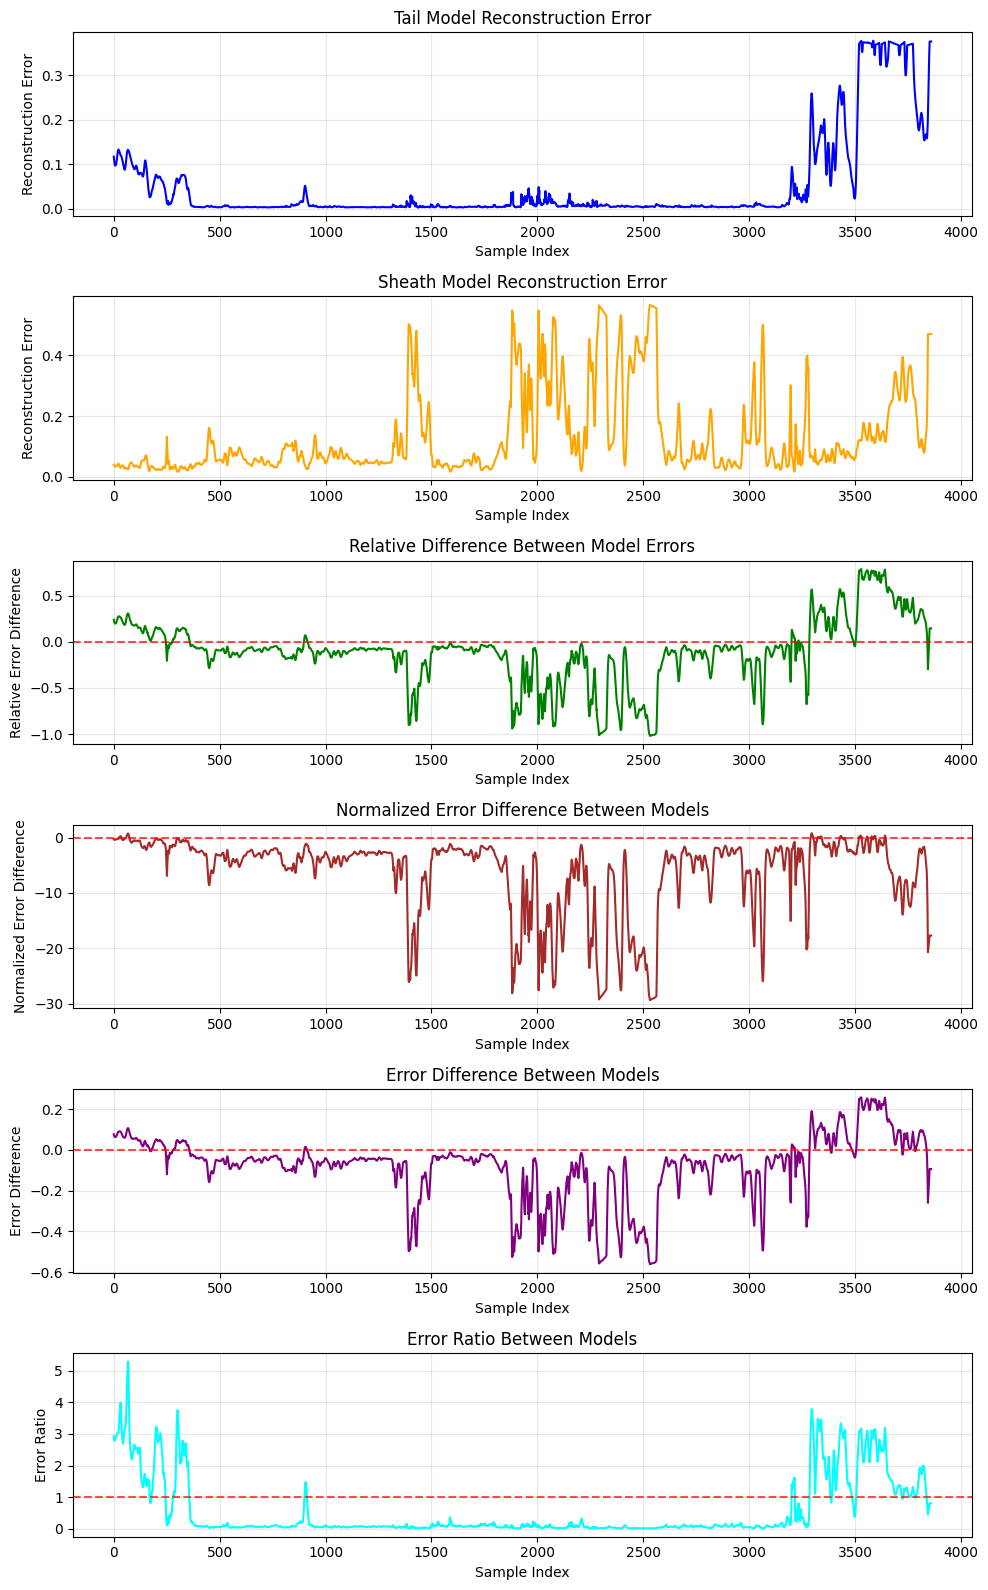

{'zero_crossing_times_relative': None,
 'zero_crossing_times_normalized': None,
 'zero_crossing_times_absolute': None,
 'true_crossings': None}

In [76]:
model.plot_results({'section_000': samples_test['section_000']}, plot=True, figsize=(10, 16) ,window_average_errors=1)

In [78]:
results = model.get_results(samples_test, crossing_times=crossing_times_ns, window_average_errors=1)

KeyboardInterrupt: 

In [64]:
score = model.get_model_score(results, time_window_minutes=30)

In [65]:
score['dataframe']

,Metric,Relative,Normalized,Absolute
0,True Positive Rate,0.339,0.174,0.388
1,False Positive Rate,0.554,0.625,0.580
2,False Negative Rate,0.661,0.826,0.612
3,True Positives,41,21,47
4,In Range Positives,63,33,66
5,Out Range Predicted Positives,45,31,48
6,False Positives,51,35,65
7,False Negatives,80,100,74
8,Precision,0.446,0.375,0.420
9,F1 Score,0.385,0.237,0.403


In [ ]:
%matplotlib inline

# Smaller test script for the following script
import os
import matplotlib.pyplot as plt

# Fixed (leftmost) hyperparameters
timestamps = 3
input_dim = 31
dim_model = [128]          # leftmost of [128, 256]
nhead_options = [4]             # leftmost of [4, 8]
num_encoder_layers = [4]
num_decoder_layers = 4
dim_feedforward = 128
mask_ratio = 0.25
patches_per_timestamp_spect = 4
n_vectors = 0
n_scalars = 0

# Only vary ion velocity inclusion
ion_velocity_options = [False, True]

# Vector options
vector_options   = [None]
# vector_options = ['ion_velocity_gsm']
# vector_options = [None, 'ion_velocity_gsm', 'magnetic_field_gsm', ['magnetic_field_gsm', 'ion_velocity_gsm']]

# Scalar options
scalar_options = ['ion_avgtemp', 'ion_density', 'ion_vthermal', 'plasma_beta', 'magnetic_field_gsm_magnitude', 'magnetic_field_gsm_x']

model_configs = []
for vector in vector_options:
    for scalar in scalar_options:
        for nhead in nhead_options:
            for n_layers in num_encoder_layers:
                for d_model in dim_model:
                    
                    data_types = ['ion_eflux']  # leftmost choices exclude magnetic field & temps/densities
                    
                    if vector is not None:
                        if isinstance(vector, list):
                            data_types.extend(vector)
                            n_vectors = len(vector)
                        else:
                            data_types.append(vector)
                            n_vectors = 1

                    if scalar is not None:
                        if isinstance(scalar, list):
                            data_types.extend(scalar)
                            n_scalars = len(scalar)
                        else:
                            data_types.append(scalar)
                            n_scalars = 1

                    model = DoubleTransformerMulti(
                        input_dim=input_dim,
                        timestamps=timestamps,
                        d_model=d_model,
                        nhead=nhead,
                        num_encoder_layers=n_layers,
                        num_decoder_layers=num_decoder_layers,
                        dim_feedforward=d_model,
                        mask_ratio=mask_ratio,
                        patches_per_timestamp_spect=patches_per_timestamp_spect,
                        n_vectors=n_vectors,
                        n_scalars=n_scalars,
                        data_types=data_types,
                        device='cuda' if torch.cuda.is_available() else 'cpu'
                    )
                    model_configs.append(model)

# Train
results = []
for i, model in enumerate(model_configs):
    print(f"Training model {i+1}/{len(model_configs)}")
    print(f"Configuration: d_model={model.d_model}, nhead={model.nhead}, data_types={model.data_types}")



    # Train with different epoch configurations and store intermediate results
    epoch_configs_1_feature = [(20, 20)]
    epoch_configs_2_features = [(15, 25)]
    
    epoch_configs = epoch_configs_2_features if model.n_vectors > 0 else epoch_configs_1_feature

    for epoch_idx, epochs in enumerate(epoch_configs):
        print(f"  Training with epochs {epochs}")
        
        # Create a fresh copy of the model for each epoch configuration
        fresh_model = DoubleTransformerMulti(
            input_dim=input_dim,
            timestamps=timestamps,
            d_model=d_model,
            nhead=model.nhead,
            num_encoder_layers=model.num_encoder_layers,
            num_decoder_layers=model.num_decoder_layers,
            dim_feedforward=model.dim_feedforward,
            mask_ratio=mask_ratio,
            patches_per_timestamp_spect=patches_per_timestamp_spect,
            n_vectors=model.n_vectors,
            n_scalars=model.n_scalars,
            data_types=model.data_types,
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )
        
        train_loss_tail, test_loss_tail, train_loss_sheath, test_loss_sheath = fresh_model.fit(
            train_samples,
            epochs=epochs,
            batch_size=96,
            learning_rate=0.001,
            test_fraction=0.1,
            exclude_sections=['']  # Use a fraction of the data for testing
        )

        results.append({
            'model': fresh_model,
            'epochs': epochs,
            'epoch_config_idx': epoch_idx,
            'train_loss_tail': train_loss_tail,
            'test_loss_tail': test_loss_tail,
            'train_loss_sheath': train_loss_sheath,
            'test_loss_sheath': test_loss_sheath,
            'config': {
                'd_model': fresh_model.d_model,
                'nhead': fresh_model.nhead,
                'data_types': fresh_model.data_types
            }
        })
        print(f"  Epochs {epochs} completed")
    print(f"Model {i+1} training completed with all epoch configurations\n")

print(f"All {len(model_configs)} models trained successfully!")



Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Training model 1/1
Configuration: d_model=128, nhead=4, data_types=['ion_eflux', 'ion_avgtemp', 'ion_density', 'electron_density', 'ion_vthermal']
  Training with epochs (20, 20)
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Starting training for 20 epochs on device: cuda
Train size: 9257, Test size: 1633, Batch size: 96
Epoch [1/20] - Train Loss: 0.737394, Test Loss: 0.375901
Epoch [2/20] - Train Loss: 0.295201, Test Loss: 0.226968
Epoch [3/20] - Train Loss: 0.226031, Test Loss: nan
Epoch [4/20] - Train Loss: 0.179780, Test Loss: 0.151076
Epoch [5/20] - Train Loss: 0.163019, Test Loss: 0.136399
Epoch [6/20] - Train Loss: 0.153855, Test Loss: 0.137894
Epoch [7/20] - Train Loss: 0.141458, Test Loss: 0.131157
Epoch [8/20] - Train Loss: 0.142339, Test Loss: 0.151253
Epoch [9/20] - Train Loss: 0.136536, Tes

In [140]:
import matplotlib

# Plot & save
matplotlib.use('Agg')  # Use non-interactive backend for saving plots

# Get current date and time for unique filenames
from datetime import datetime
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
current_date = datetime.now().strftime("%Y-%m-%d")

directory_name = f'model_results_plots_{current_date}_test10_4_scalars'

os.makedirs(directory_name, exist_ok=True)
for i, result in enumerate(results):
    model = result['model']
    config = result['config']
    filename = f"model_{i+1}_d{config['d_model']}_h{config['nhead']}_features_{len(config['data_types'])}_epochs_[{result['epochs'][0]},{result['epochs'][1]}]_{current_time}.png"
    print(f"Plotting results for model {i+1}/{len(results)}")

    fig, axes = model.plot_results(testing_samples, figsize=(8, 14))
    fig.suptitle(
        f"Model {i+1}: d_model={config['d_model']}, nhead={config['nhead']}\nFeatures: {config['data_types']}",
        fontsize=10, y=0.98
    )
    
    # Save before closing
    plt.savefig(os.path.join(directory_name, filename), dpi=300, bbox_inches='tight')
    plt.close(fig)  # Close the specific figure, not all figures

print(f"All plots saved to '{directory_name}' folder!")

# Reset to widget backend if needed for interactive plots
matplotlib.use('widget')

Plotting results for model 1/1
All plots saved to 'model_results_plots_2025-08-19_test10_4_scalars' folder!


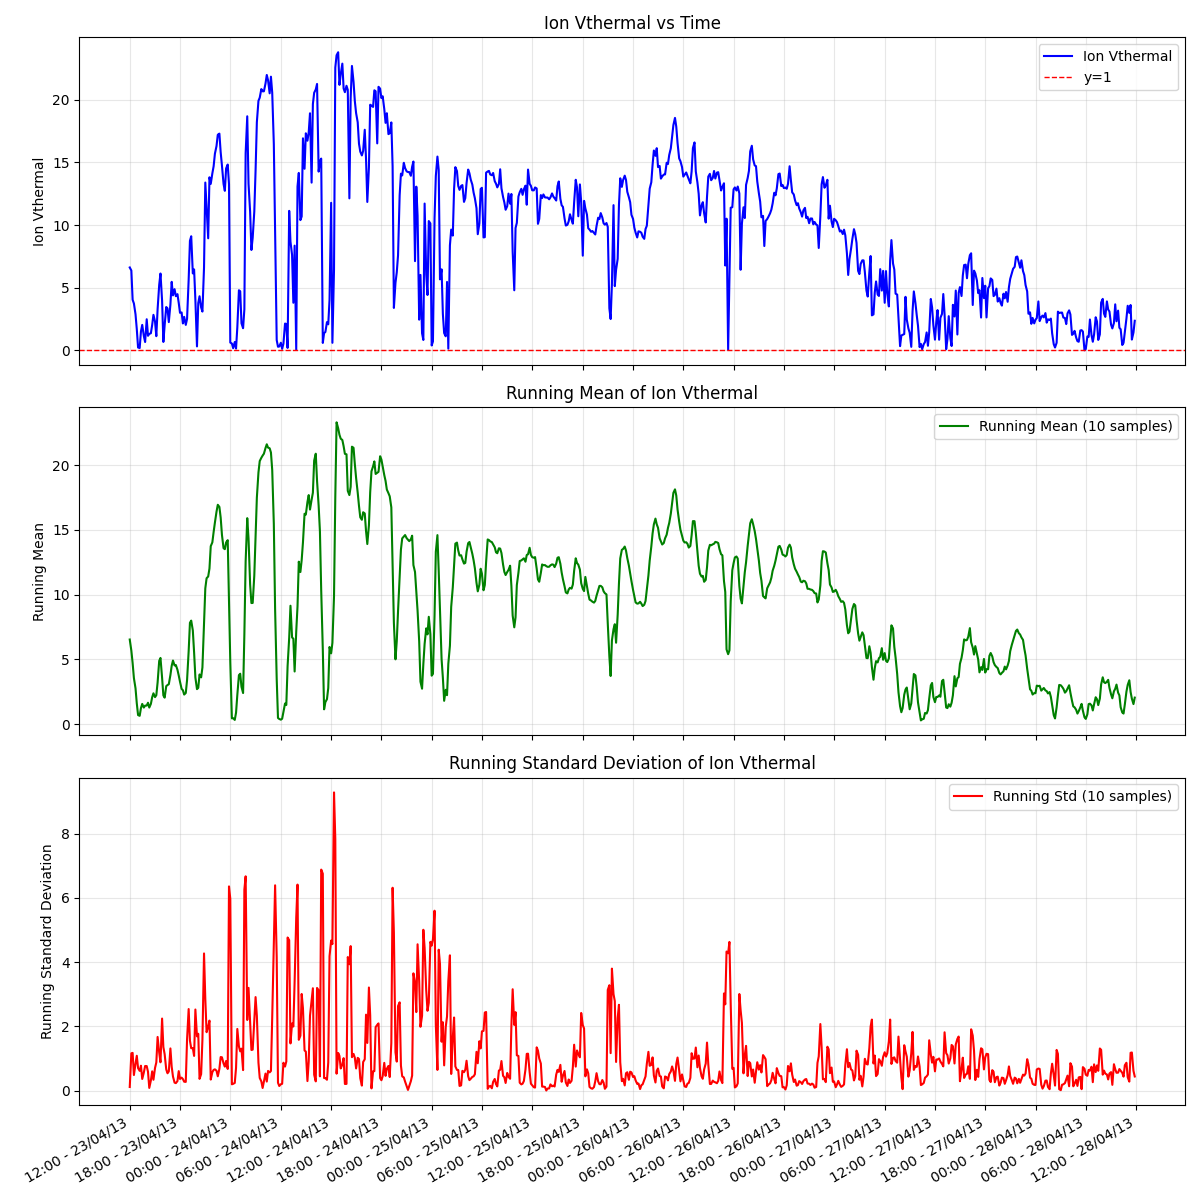

In [253]:

# Get the electron density data
# electron_density = torch.sqrt(torch.sum(testing_samples['section_000']['magnetic_field_gsm']**2, dim=-1)) # Example: using the first component of magnetic field

electron_density = testing_samples['section_000']['magnetic_field_gsm_x'] # Example: using ion_vthermal

# Get section times
# section_times = testing_dataset.get_section_times()['section_000']


# Floor the electron density to avoid negative values
# electron_density, _, _ = downweight_variable(electron_density, p=41, win=3, smoother_win=15, mode='exp', wmin=0.05)

log_data = False # Set to True if you want to log the data

# Remove outliers of electron density
if log_data:
    electron_density = torch.log(electron_density)

# Calculate running mean and standard deviation with window size 10
window_size = 3
electron_density_np = electron_density.cpu().numpy()

# Pad the data for edge handling
padded_data = np.pad(electron_density_np, window_size//2, mode='edge')

# Calculate running statistics
running_mean = []
running_std = []

for i in range(len(electron_density_np)):
    window_data = padded_data[i:i+window_size]
    running_mean.append(np.mean(window_data))
    running_std.append(np.std(window_data))

running_mean = np.array(running_mean)
running_std = np.array(running_std)

# Create time axis
if section_times is not None:
    time_axis = section_times
elif 'times' in testing_samples['section_000']:
    times = testing_samples['section_000']['times']
    time_axis = range(len(times))
else:
    time_axis = range(len(electron_density))

# Create the plot with subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
# Plot 1: Original electron density
ax1.plot(time_axis, electron_density_np, linewidth=1.5, color='blue', label='Ion Vthermal')
ax1.axhline(y=np.log(1), color='red', linestyle='--', linewidth=1, label='y=1')
ax1.set_ylabel('Ion Vthermal')
ax1.set_title('Ion Vthermal vs Time')
ax1.grid(True, alpha=0.3)
if section_times is not None:
    ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M %d-%m-%Y'))
    ax1.xaxis.set_major_locator(matplotlib.dates.HourLocator(interval=6))
    fig.autofmt_xdate()
ax1.legend()

# Plot 2: Running mean
ax2.plot(time_axis, running_mean, linewidth=1.5, color='green', label='Running Mean (10 samples)')
ax2.set_ylabel('Running Mean')
ax2.set_title('Running Mean of Ion Vthermal')
ax2.grid(True, alpha=0.3)
if section_times is not None:
    ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M %d-%m-%Y'))
    ax2.xaxis.set_major_locator(matplotlib.dates.HourLocator(interval=6))
    fig.autofmt_xdate()

ax2.legend()

# Plot 3: Running standard deviation
ax3.plot(time_axis, running_std, linewidth=1.5, color='red', label='Running Std (10 samples)')
ax3.set_ylabel('Running Standard Deviation')
ax3.set_title('Running Standard Deviation of Ion Vthermal')
ax3.grid(True, alpha=0.3)
if section_times is not None:
    ax3.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M - %d/%m/%y'))
    ax3.xaxis.set_major_locator(matplotlib.dates.HourLocator(interval=6))
    fig.autofmt_xdate(bottom=0.5)

ax3.legend()


plt.tight_layout()
plt.show()

In [118]:
np.where(electron_density_np > 130)

(array([109], dtype=int64),)

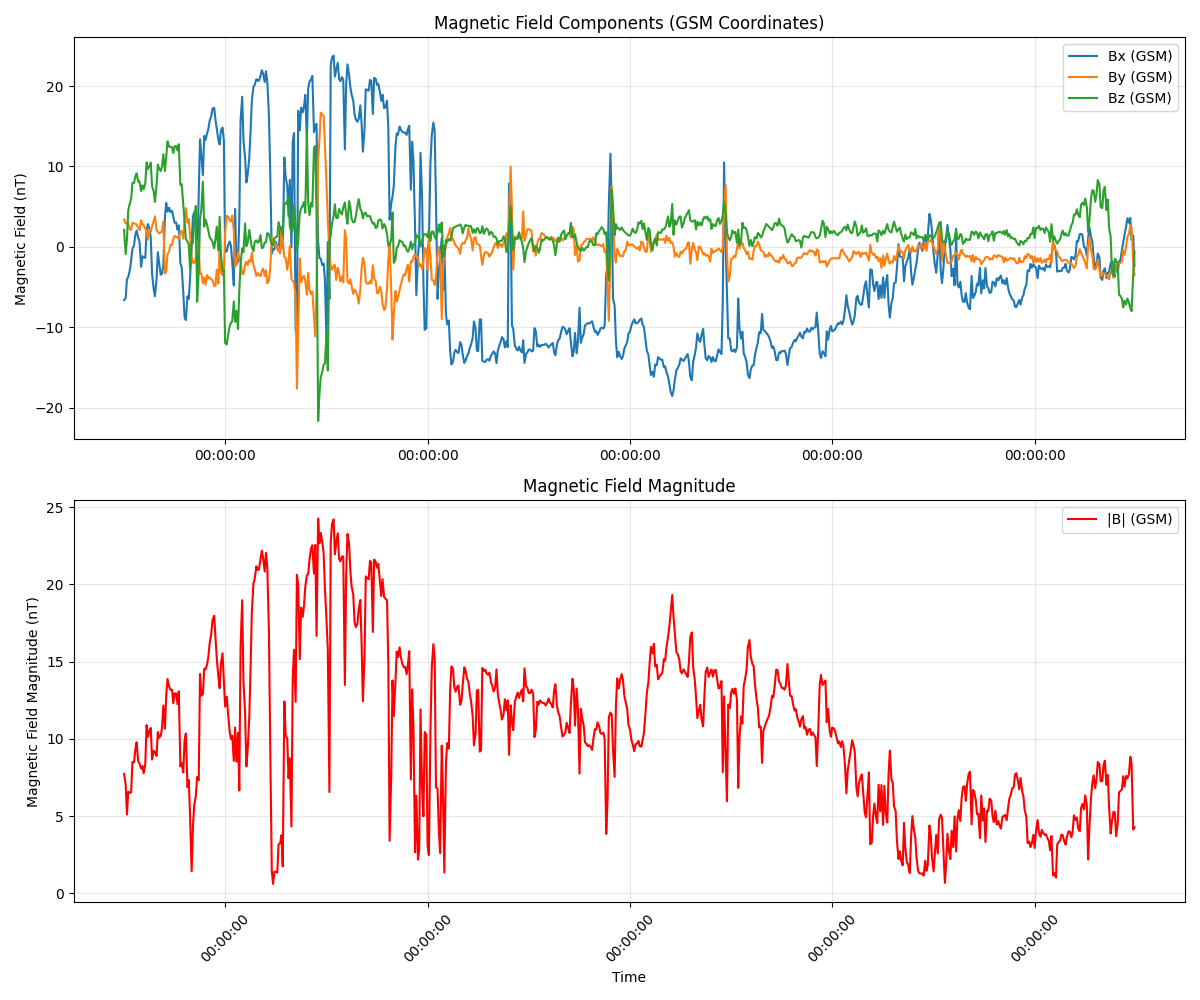

In [ ]:
from datetime import datetime, timezone
from matplotlib import dates as mdates
import numpy as np
Figure 22

# Get the magnetic field data
mag_field = testing_samples['section_000']['magnetic_field_gsm']



# Get the times and convert to datetime
time_ns = testing_samples['section_000']['times'].cpu().numpy().astype('int64')
time_s = time_ns / 1e9
times_datetime = [datetime.fromtimestamp(ts, timezone.utc) for ts in time_s]

# Calculate magnetic field magnitude
mag_field_magnitude = torch.sqrt(mag_field[:, 0]**2 + mag_field[:, 1]**2 + mag_field[:, 2]**2)
# Calculate the standard deviation of the magnetic field magnitude
mag_field_magnitude_std = torch.std(mag_field_magnitude)

# Remove all values above 3 standard deviations from the mean and replace with interpolated of surrounding values
mean_magnitude = torch.mean(mag_field_magnitude)
mag_field_magnitude[mag_field_magnitude > mean_magnitude + 3 * mag_field_magnitude_std] = np.nan
# Use torch.isnan to find NaN values and interpolate them
nan_mask = torch.isnan(mag_field_magnitude)
if nan_mask.any():
    # Get indices of valid (non-NaN) values
    valid_indices = torch.where(~nan_mask)[0]
    nan_indices = torch.where(nan_mask)[0]
    
    if len(valid_indices) > 1:
        # Interpolate NaN values using linear interpolation
        mag_field_magnitude[nan_indices] = torch.tensor(np.interp(
            nan_indices.cpu().numpy(),
            valid_indices.cpu().numpy(),
            mag_field_magnitude[valid_indices].cpu().numpy()
        ), dtype=mag_field_magnitude.dtype).to(mag_field_magnitude.device)




# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# First plot - Components
ax1.plot(times_datetime, mag_field[:, 0].cpu().numpy(), label='Bx (GSM)', linewidth=1.5)
ax1.plot(times_datetime, mag_field[:, 1].cpu().numpy(), label='By (GSM)', linewidth=1.5)
ax1.plot(times_datetime, mag_field[:, 2].cpu().numpy(), label='Bz (GSM)', linewidth=1.5)

ax1.set_ylabel('Magnetic Field (nT)')
ax1.set_title('Magnetic Field Components (GSM Coordinates)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Second plot - Magnitude
ax2.plot(times_datetime, mag_field_magnitude.cpu().numpy(), label='|B| (GSM)', linewidth=1.5, color='red')

ax2.set_xlabel('Time')
ax2.set_ylabel('Magnetic Field Magnitude (nT)')
ax2.set_title('Magnetic Field Magnitude')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Define how many time steps to use for the input
timestamps = 4

# Initialize the autoencoder
MAE_transformer = DoubleTransformerMulti(
    input_dim= 31, 
    timestamps = timestamps, 
    d_model = 128, 
    nhead = 4, 
    num_encoder_layers = 4,            
    num_decoder_layers = 4, 
    dim_feedforward = 128, 
    mask_ratio = 0.25,
    patches_per_timestamp_spect = 4,
    n_vectors = 2,
    n_scalars = 0,
    data_types=['ion_eflux', 
                'magnetic_field_gsm', 
                'ion_velocity_gsm', 
                # 'electron_velocity_gsm',
                # 'ion_avgtemp', 
                # 'ion_density', 
                # 'electron_avgtemp',
                # 'electron_density',
                # 'electron_vthermal'
                ]
    )

# Create a list to store all model configurations
model_configs = []

# Define parameter combinations
d_models = [128, 256]
nheads = [4, 8]
magnetic_field_options = [False, True]  # False = exclude, True = include
ion_velocity_options = [False, True]
ion_temp_density_options = [False, True]  # False = exclude all three, True = include all three

# Generate all combinations
for d_model in d_models:
    for nhead in nheads:
        for use_magnetic in magnetic_field_options:
            for use_ion_vel in ion_velocity_options:
                for use_ion_temp in ion_temp_density_options:
                    # Build data_types list based on options
                    data_types = ['ion_eflux']
                    
                    if use_magnetic:
                        data_types.append('magnetic_field_gsm')
                    
                    if use_ion_vel:
                        data_types.append('ion_velocity_gsm')
                    
                    if use_ion_temp:
                        data_types.extend(['ion_avgtemp', 'ion_density', 'electron_avgtemp'])
                    
                    # Create model configuration
                    model = DoubleTransformerMulti(
                        input_dim=31, 
                        timestamps=timestamps, 
                        d_model=d_model, 
                        nhead=nhead, 
                        num_encoder_layers=4,            
                        num_decoder_layers=4, 
                        dim_feedforward=128, 
                        mask_ratio=0.25,
                        patches_per_timestamp_spect=4,
                        n_vectors=2,
                        n_scalars=0,
                        data_types=data_types
                    )
                    
                    model_configs.append(model)

# Train all model configurations
results = []

for i, model in enumerate(model_configs):
    print(f"Training model {i+1}/{len(model_configs)}")
    print(f"Configuration: d_model={model.d_model}, nhead={model.nhead}, data_types={model.data_types}")
    
    # Determine epochs based on d_model
    epochs = (20, 35) if model.d_model == 256 else (15, 25)
    
    # Train the model
    train_loss_tail, test_loss_tail, train_loss_sheath, test_loss_sheath = \
        model.fit(train_samples, 
                    epochs=epochs,
                    batch_size=96,
                    learning_rate=0.001)
    
    # Store results
    results.append({
        'model': model,
        'train_loss_tail': train_loss_tail,
        'test_loss_tail': test_loss_tail,
        'train_loss_sheath': train_loss_sheath,
        'test_loss_sheath': test_loss_sheath,
        'config': {
            'd_model': model.d_model,
            'nhead': model.nhead,
            'data_types': model.data_types
        }
    })
    
    print(f"Model {i+1} training completed\n")

print(f"All {len(model_configs)} models trained successfully!")


import matplotlib.pyplot as plt

# Create folder to store figures
os.makedirs('model_results_plots', exist_ok=True)

# Plot results for all models
for i, result in enumerate(results):
    model = result['model']
    config = result['config']
    
    # Generate a descriptive filename
    filename = f"model_{i+1}_d{config['d_model']}_h{config['nhead']}_features_{len(config['data_types'])}.png"
    
    print(f"Plotting results for model {i+1}/{len(results)}")
    
    # Plot results using the model's plot_results method
    fig, axes = model.plot_results(train_samples, figsize=(8, 14))
    
    # Add title with configuration info
    fig.suptitle(f"Model {i+1}: d_model={config['d_model']}, nhead={config['nhead']}\nFeatures: {config['data_types']}", 
                 fontsize=10, y=0.98)
    
    # Save the figure
    plt.savefig(os.path.join('model_results_plots', filename), 
                dpi=300, bbox_inches='tight')
    plt.close()

print(f"All plots saved to 'model_results_plots' folder!")

Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_dim from 31 to 32 to make it divisible by 4
Padding input_

AttributeError: 'DoubleTransformerMulti' object has no attribute 'd_model'

In [80]:
train_loss_tail, test_loss_tail,train_loss_sheath, test_loss_sheath = \
    MAE_transformer.fit(train_samples, 
                        epochs=(15, 25),
                        batch_size=96,
                        learning_rate=0.001)

Starting training for 15 epochs...
Train size: 3497, Test size: 616, Batch size: 96
Epoch [1/15] - Train Loss: 1.109479, Test Loss: 0.897021
Epoch [2/15] - Train Loss: 0.830895, Test Loss: 0.816740
Epoch [3/15] - Train Loss: 0.646955, Test Loss: 0.538261
Epoch [4/15] - Train Loss: 0.496919, Test Loss: 0.391422
Epoch [5/15] - Train Loss: 0.378075, Test Loss: 0.304099
Epoch [6/15] - Train Loss: 0.325844, Test Loss: 0.255109
Epoch [7/15] - Train Loss: 0.265216, Test Loss: 0.215549
Epoch [8/15] - Train Loss: 0.231868, Test Loss: 0.209526
Epoch [9/15] - Train Loss: 0.213236, Test Loss: 0.188991
Epoch [10/15] - Train Loss: 0.211016, Test Loss: 0.219906
Epoch [11/15] - Train Loss: 0.196331, Test Loss: 0.200839
Epoch [12/15] - Train Loss: 0.200520, Test Loss: 0.181134
Epoch [13/15] - Train Loss: 0.192379, Test Loss: 0.188365
Epoch [14/15] - Train Loss: 0.192681, Test Loss: 0.173068
Epoch [15/15] - Train Loss: 0.185654, Test Loss: 0.169354
Training completed!
Starting training for 25 epochs...


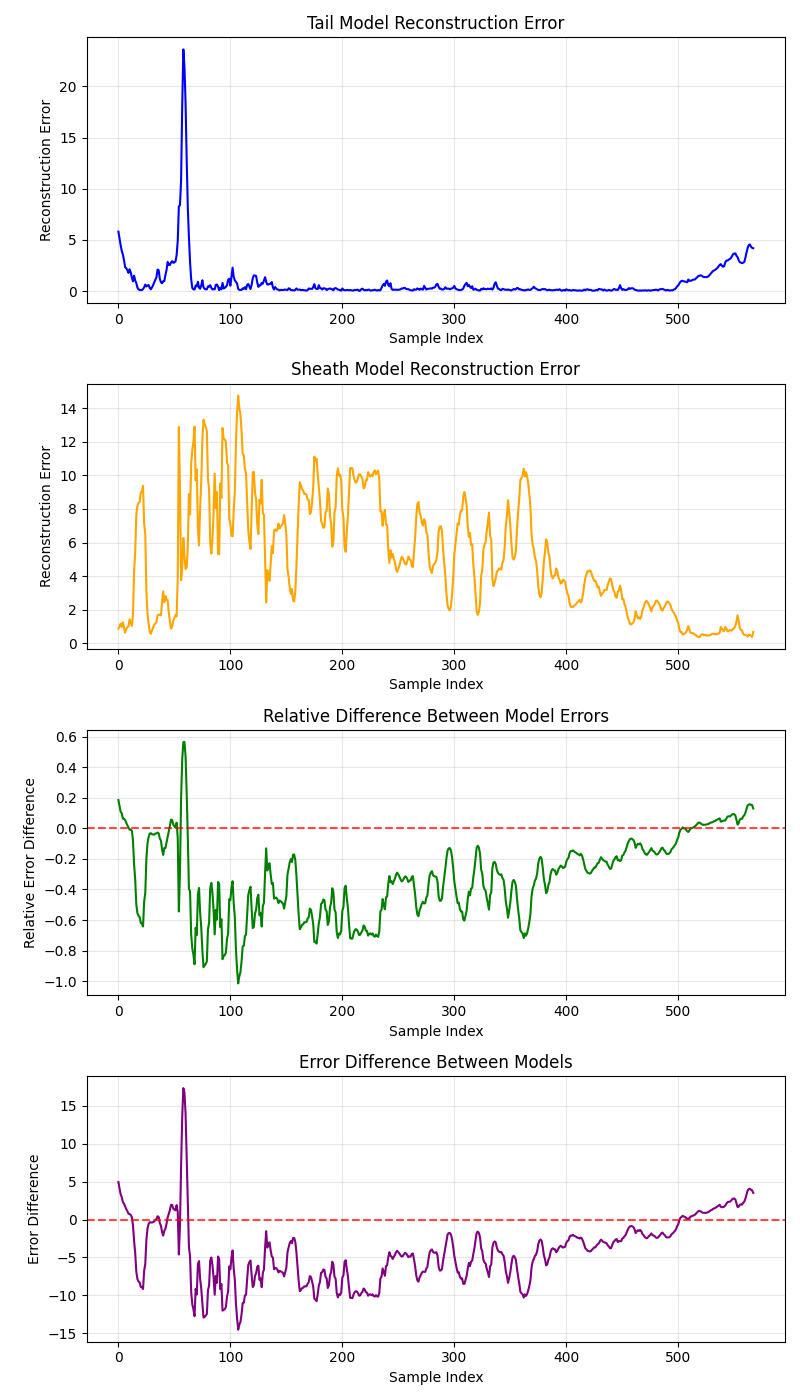

In [81]:
MAE_transformer.plot_results(testing_samples, figsize=(8, 14))

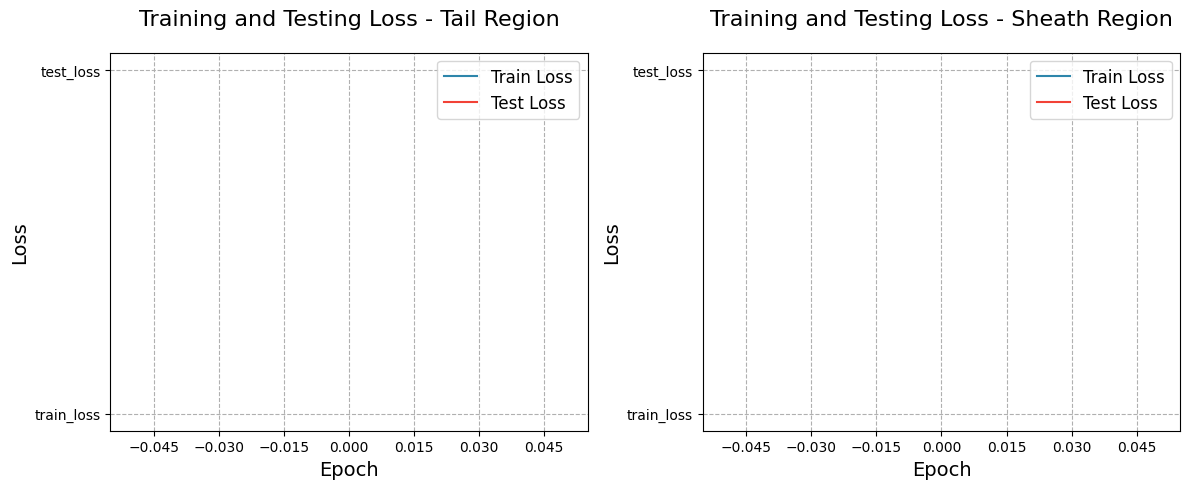

: 

In [ ]:
# Plotting the training and testing loss for the tail and sheath regions

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(train_loss_tail, label='Train Loss', color='#2E86AB')
axs[0].plot(test_loss_tail, label='Test Loss', color='#F24236')
axs[0].set_xlabel('Epoch', fontsize=14)
axs[0].set_ylabel('Loss', fontsize=14)
axs[0].set_title('Training and Testing Loss - Tail Region', fontsize=16, pad=20)
axs[0].legend(fontsize=12)
axs[0].grid(True, alpha=1, linestyle='--')
axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

axs[1].plot(train_loss_sheath, label='Train Loss', color='#2E86AB')
axs[1].plot(test_loss_sheath, label='Test Loss', color='#F24236')
axs[1].set_xlabel('Epoch', fontsize=14)
axs[1].set_ylabel('Loss', fontsize=14)
axs[1].set_title('Training and Testing Loss - Sheath Region', fontsize=16, pad=20)
axs[1].legend(fontsize=12)
axs[1].grid(True, alpha=1, linestyle='--')
axs[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

In [ ]:
test_samples = testing_dataset.get_trainable_samples()

In [ ]:
results_tail_model, results_sheath_model, prepared_data = MAE_transformer.predict(test_samples)

In [ ]:
n_sample = 65

test_sample_example = prepared_data[n_sample, :, :].cpu().numpy()
result_tail_model_example = results_tail_model[n_sample, :, :].cpu().numpy()
result_sheath_model_example = results_sheath_model[n_sample, :, :].cpu().numpy()

13-Jul-25 17:35:41: C:\Users\ianma\AppData\Local\Temp\ipykernel_20620\647492426.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks[::-1])

13-Jul-25 17:35:41: C:\Users\ianma\AppData\Local\Temp\ipykernel_20620\647492426.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks[::-1])

13-Jul-25 17:35:41: C:\Users\ianma\AppData\Local\Temp\ipykernel_20620\647492426.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks[::-1])



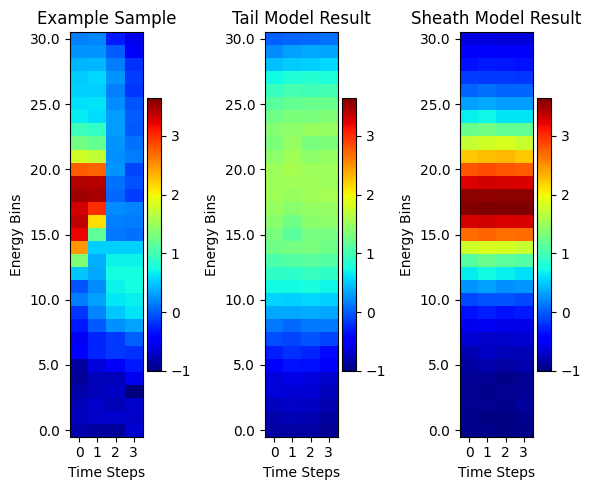

In [ ]:
import matplotlib.ticker as ticker

fig, axs = plt.subplots(1, 3, figsize=(6, 5))

# Find global min and max across all data
vmin = min(test_sample_example.min(), result_tail_model_example.min(), result_sheath_model_example.min())
vmax = max(test_sample_example.max(), result_tail_model_example.max(), result_sheath_model_example.max())

def invert_yaxis_ticks(ax):
    yticks = ax.get_yticks()
    ax.set_yticklabels(yticks[::-1])

# Plot test sample example
im1 = axs[0].imshow(test_sample_example.T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax)
axs[0].set_title('Example Sample')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Energy Bins')
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
axs[0].yaxis.set_major_locator(ticker.MultipleLocator(5))
axs[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%i'))

plt.colorbar(im1, ax=axs[0])
invert_yaxis_ticks(axs[0])

# Plot tail model result
im2 = axs[1].imshow(result_tail_model_example.T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax)
axs[1].set_title('Tail Model Result')
axs[1].set_xlabel('Time Steps')
axs[1].set_ylabel('Energy Bins')
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(1))
axs[1].yaxis.set_major_locator(ticker.MultipleLocator(5))
axs[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%i'))

plt.colorbar(im2, ax=axs[1])
invert_yaxis_ticks(axs[1])

# Plot sheath model result
im3 = axs[2].imshow(result_sheath_model_example.T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax)
axs[2].set_title('Sheath Model Result')
axs[2].set_xlabel('Time Steps')
axs[2].set_ylabel('Energy Bins')
axs[2].xaxis.set_major_locator(ticker.MultipleLocator(1))
axs[2].yaxis.set_major_locator(ticker.MultipleLocator(5))
axs[2].yaxis.set_major_formatter(ticker.FormatStrFormatter('%i'))

plt.colorbar(im3, ax=axs[2])
invert_yaxis_ticks(axs[2])

plt.tight_layout()
plt.show()


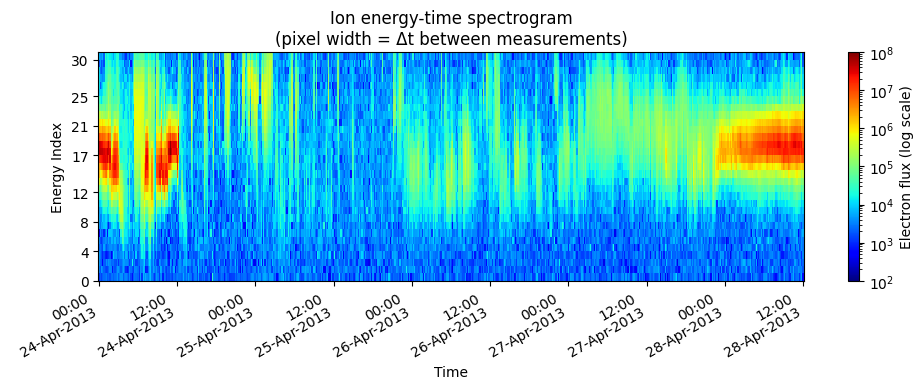

Invalid input. Please enter '1' for magnetotail or '2' for magnetosheath.
Due to invalid input, region was set to None


In [ ]:
testing_dataset.set_regions_for_sections()

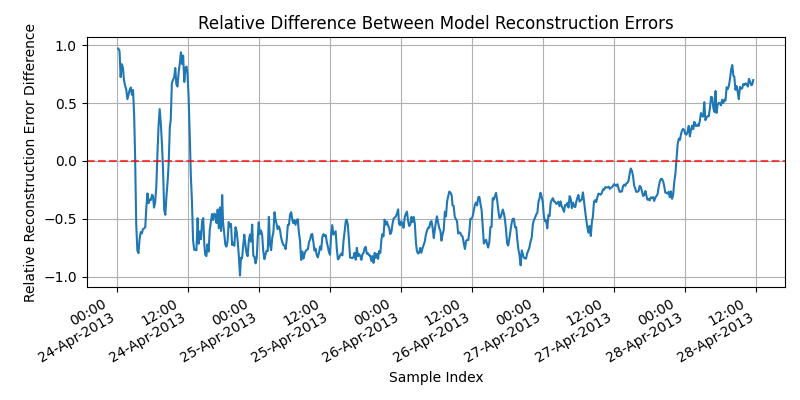

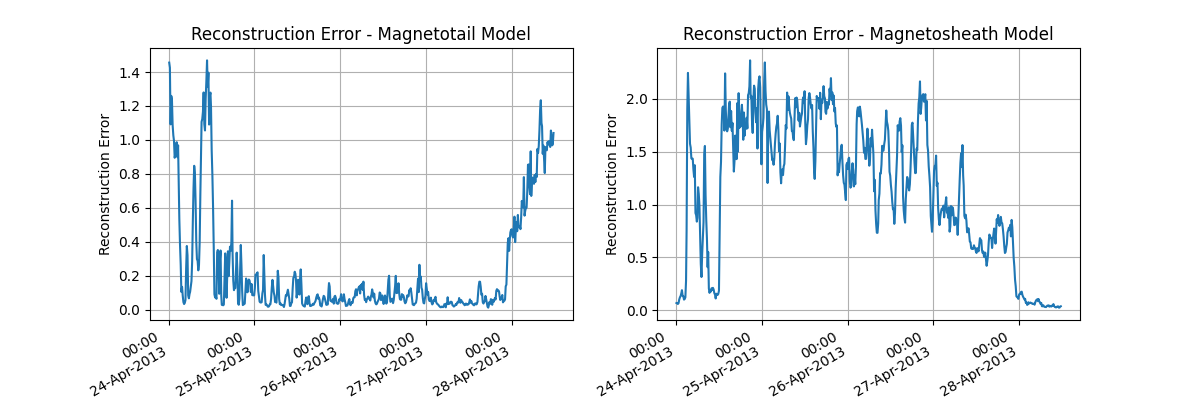

In [ ]:
%matplotlib widget
_ = MAE_transformer.plot_results(test_samples, times=test_samples['section_000']['times'], figsize=(12, 4))

In [ ]:
section_to_region_map = dataset.get_section_to_region_map()

In [ ]:
import datetime

for key in train_samples.keys():

    # Get the time data from train_samples
    sample_times = train_samples[key]['times']

    # Get the first time (nanoseconds since 1970)
    first_time_ns = sample_times[0].item()  # Convert tensor to Python number

    # Convert nanoseconds to seconds
    first_time_s = first_time_ns / 1e9

    # Convert to datetime
    first_time_datetime = datetime.datetime.fromtimestamp(first_time_s)

    print(f"First timestamp: {first_time_datetime}")


First timestamp: 2011-08-14 02:00:52.837745
First timestamp: 2011-08-15 20:39:32.148773
First timestamp: 2011-11-12 00:58:56.508330
First timestamp: 2011-11-12 07:44:23.203094
First timestamp: 2011-11-13 05:36:55.723434
First timestamp: 2011-11-14 00:35:22.883310
First timestamp: 2011-08-16 02:00:13.602259
First timestamp: 2011-08-16 04:35:59.451095
First timestamp: 2011-08-17 11:03:55.735966
First timestamp: 2011-11-09 01:01:04.081035
First timestamp: 2011-09-13 23:09:15.241497
First timestamp: 2011-09-14 16:22:20.209512
First timestamp: 2011-09-15 02:33:56.410089
First timestamp: 2012-02-08 00:59:56.853354
First timestamp: 2012-02-09 15:06:00.928920
First timestamp: 2012-05-02 01:59:58.230397
First timestamp: 2012-05-04 09:05:22.640257
First timestamp: 2012-11-27 01:08:22.327083
First timestamp: 2012-11-30 03:00:46.702051
First timestamp: 2012-11-30 13:05:30.585768
First timestamp: 2011-12-08 05:00:07.292944
First timestamp: 2011-12-10 09:29:45.853968
First timestamp: 2012-01-07 04:2

In [ ]:
test_samples['section_000']['B_ion_eflux'].shape

torch.Size([574, 31])

In [ ]:
import torch.nn.functional as F

# Apply window averaging with padding
# Input shape: [timesteps, energybins]
B_ion_eflux = test_samples['section_000']['B_ion_eflux']

# Add batch and channel dimensions for conv1d: [batch, channels, timesteps]
B_ion_eflux_expanded = B_ion_eflux.transpose(0, 1).unsqueeze(0)  # [1, energybins, timesteps]

# Create averaging kernel of size 5
kernel = torch.ones(1, 1, 3) / 3.0  # [out_channels, in_channels, kernel_size]

# Apply 1D convolution with padding=2 to maintain original length
B_ion_eflux_smoothed = F.conv1d(B_ion_eflux_expanded, kernel.expand(B_ion_eflux_expanded.size(1), 1, -1), 
                                padding=1, groups=B_ion_eflux_expanded.size(1))

# Reshape back to original format: [timesteps, energybins]
B_ion_eflux_smoothed = B_ion_eflux_smoothed.squeeze(0).transpose(0, 1)

print(f"Original shape: {B_ion_eflux.shape}")
print(f"Smoothed shape: {B_ion_eflux_smoothed.shape}")

Original shape: torch.Size([574, 31])
Smoothed shape: torch.Size([574, 31])


In [ ]:
B_ion_eflux_smoothed.shape

torch.Size([574, 31])

In [ ]:
B_ion_eflux_smoothed.max(dim=1).values

tensor([2.8203e+07, 4.2978e+07, 4.4461e+07, 4.0188e+07, 3.4512e+07, 2.9119e+07,
        3.3388e+07, 3.6418e+07, 3.6895e+07, 2.1979e+07, 1.4209e+07, 1.2615e+07,
        2.0085e+07, 2.1175e+07, 1.7127e+07, 1.0682e+07, 5.6941e+06, 2.6014e+06,
        4.9118e+05, 2.9509e+05, 1.6049e+05, 6.2198e+04, 3.5504e+04, 2.4211e+04,
        3.8261e+04, 3.2890e+04, 3.2749e+04, 3.1485e+04, 2.6843e+05, 4.5735e+05,
        6.7076e+05, 6.3769e+05, 6.7766e+05, 6.7025e+05, 6.6301e+05, 6.0933e+05,
        1.3071e+06, 8.9965e+06, 1.7103e+07, 1.8456e+07, 1.2680e+07, 2.4172e+06,
        1.9095e+06, 1.7446e+06, 1.4637e+06, 1.2379e+05, 3.0459e+06, 6.7355e+06,
        1.6580e+07, 2.3192e+07, 2.2780e+07, 1.9986e+07, 1.5960e+07, 1.9241e+07,
        1.9324e+07, 2.2417e+07, 1.9268e+07, 5.4485e+07, 6.6676e+07, 5.8144e+07,
        3.0937e+07, 3.1142e+07, 2.9256e+07, 2.3889e+07, 2.0555e+07, 1.2313e+07,
        1.1420e+07, 5.7221e+04, 5.7844e+04, 4.7111e+04, 2.7307e+04, 1.4632e+04,
        8.9172e+03, 7.8218e+03, 2.1018e+

In [ ]:
avg_test_samples = torch.log(B_ion_eflux_smoothed).mean(dim=1)
std_test_samples = torch.log(B_ion_eflux_smoothed).std(dim=1)

avg_test_samples_norm = (avg_test_samples) / (avg_test_samples.max() - avg_test_samples.min())
std_test_samples_norm = (std_test_samples) / (torch.log(B_ion_eflux_smoothed).max(dim=1).values - torch.log(B_ion_eflux_smoothed).min(dim=1).values)

In [ ]:
opp_avg_test_samples = 1/avg_test_samples_norm 
opp_avg_test_samples_norm = (opp_avg_test_samples) / (opp_avg_test_samples.max() - opp_avg_test_samples.min())

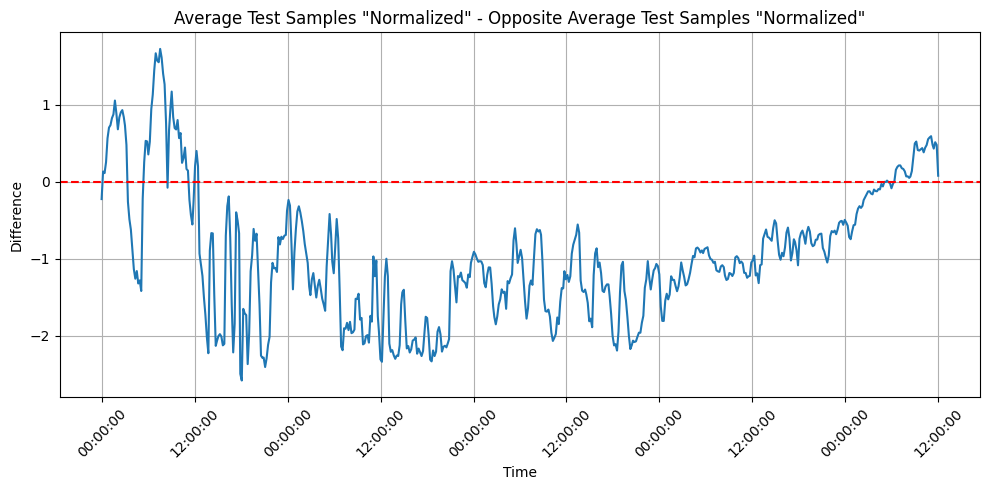

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from matplotlib import dates as mdates
import numpy as np

time_ns = test_samples['section_000']['times'].cpu().numpy().astype('int64')
time_s = time_ns / 1e9
times_datetime = [datetime.fromtimestamp(ts, timezone.utc) for ts in time_s]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(times_datetime,avg_test_samples.numpy() - 2*std_test_samples_norm.numpy() - 10, label='Average Test Samples Normalized')    
ax.set_title('Average Test Samples "Normalized" - Opposite Average Test Samples "Normalized"')
ax.set_xlabel('Time')
ax.set_ylabel("Difference")
ax.axhline(0, color='red', linestyle='--', label='Zero Line')
ax.grid()
ax.xaxis_date()
# Format the x-axis to display times nicely
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
 

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

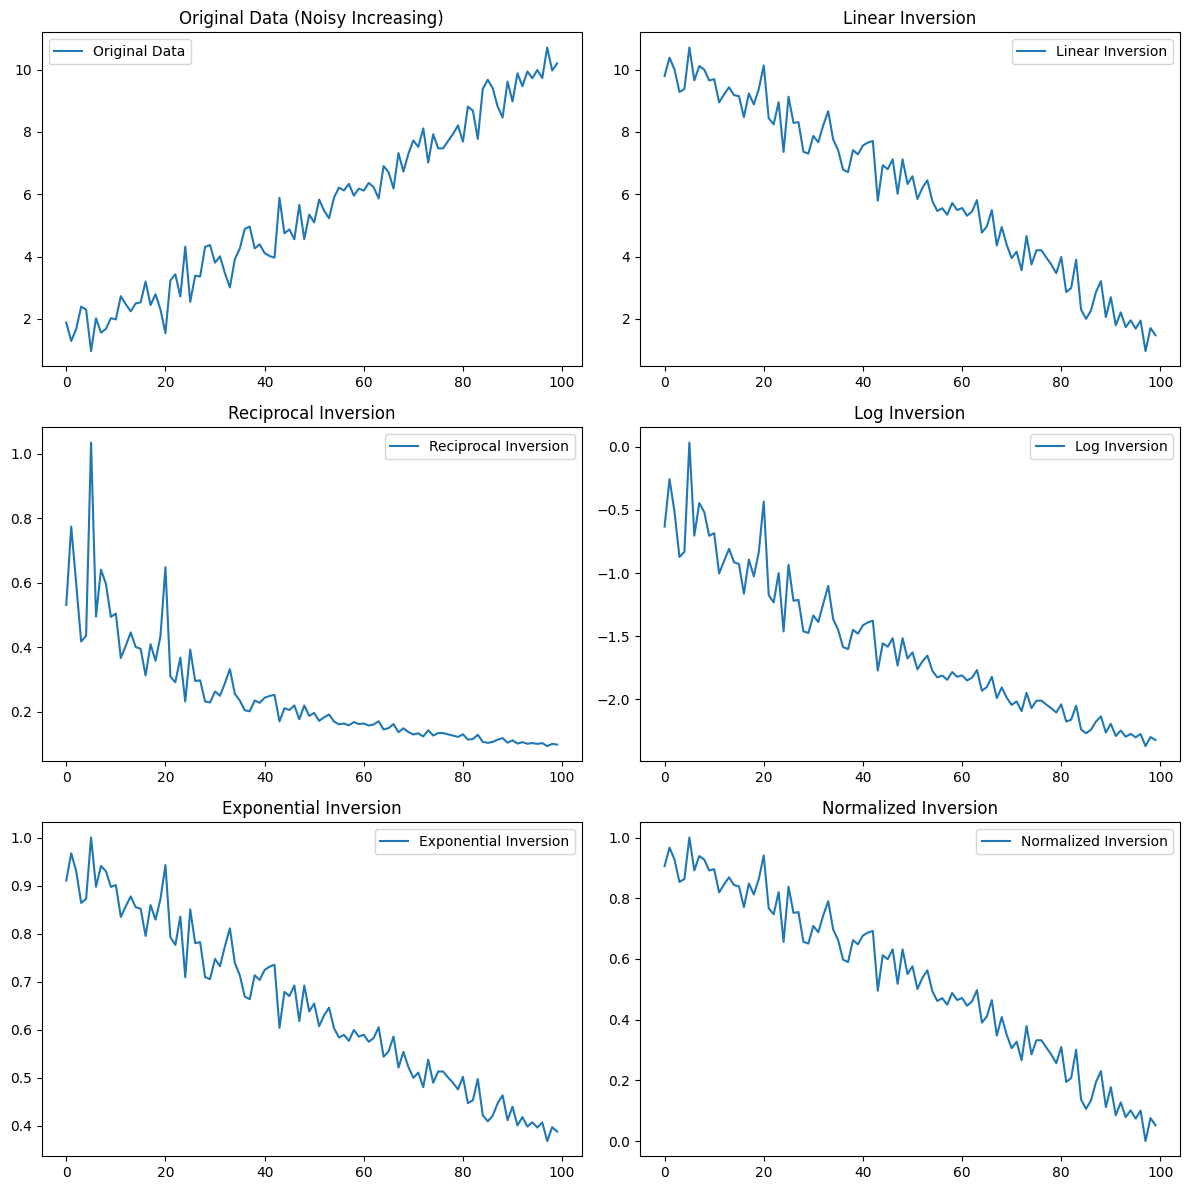

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate noisy increasing data
np.random.seed(0)
x = np.linspace(1, 10, 100) + np.random.normal(0, 0.5, 100)  # avoid zero for log/reciprocal
x = np.clip(x, 1e-3, None)  # Ensure all values are > 0

# Define transformation functions
def linear_inversion(x):
    return np.max(x) + np.min(x) - x

def reciprocal_inversion(x):
    return 1.0 / (x + 1e-5)

def log_inversion(x):
    return -np.log(x + 1e-5)

def exp_inversion(x):
    x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))
    return np.exp(-x_norm)

def normalized_inversion(x):
    return (np.max(x) - x) / (np.max(x) - np.min(x))

# Apply transformations
y_linear = linear_inversion(x)
y_recip = reciprocal_inversion(x)
y_log = log_inversion(x)
y_exp = exp_inversion(x)
y_norm = normalized_inversion(x)

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs = axs.ravel()

axs[0].plot(x, label='Original Data')
axs[0].set_title('Original Data (Noisy Increasing)')
axs[0].legend()

axs[1].plot(y_linear, label='Linear Inversion')
axs[1].set_title('Linear Inversion')
axs[1].legend()

axs[2].plot(y_recip, label='Reciprocal Inversion')
axs[2].set_title('Reciprocal Inversion')
axs[2].legend()

axs[3].plot(y_log, label='Log Inversion')
axs[3].set_title('Log Inversion')
axs[3].legend()

axs[4].plot(y_exp, label='Exponential Inversion')
axs[4].set_title('Exponential Inversion')
axs[4].legend()

axs[5].plot(y_norm, label='Normalized Inversion')
axs[5].set_title('Normalized Inversion')
axs[5].legend()

plt.tight_layout()
plt.show()